In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

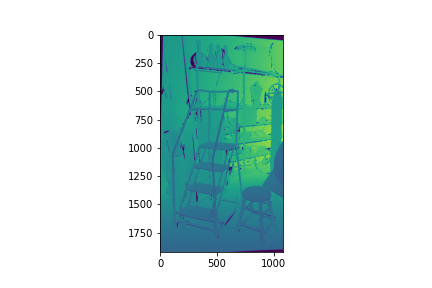

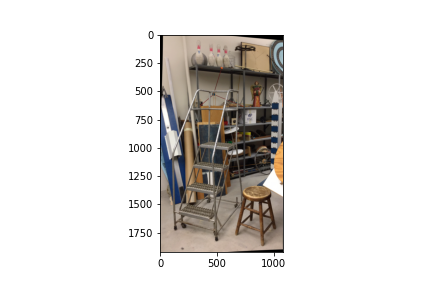

In [29]:
img_path = "~/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "~/data/middlebury/all/data/ladder1/disp0.pfm"
img_path = "/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)


In [30]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [31]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, point_size=1,eye_dome_lighting=True)

In [59]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("QT5Agg")
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

you must annotate the same amount of points in each image


NameError: name 'exit' is not defined

In [ ]:
#cps[:,2:] = cps[:,:2]

In [ ]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

#cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
# [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
# [   1002.03,    1674.41 ,    994.27  ,  1664.08],
# [    968.43 ,   1540.05,     968.43  ,  1545.22],
# [    890.92 ,   1586.56,     885.75   , 1583.97],
# [    735.88 ,   1532.30   ,  738.46   , 1534.88],
# [    141.57 ,    863.05   ,  138.99  ,   870.81]])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

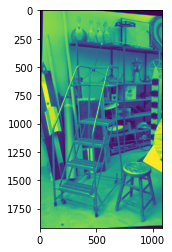

In [ ]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [ ]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,2:])
world_pts

array([[  -2040.63,   -1956.36,    7326.76],
       [   -847.75,   -1830.91,    6856.96],
       [   1157.00,   -2490.50,    9949.58],
       [    243.65,    2230.25,    6272.49]], dtype=float32)

In [ ]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [ ]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00       0.00       0.01     -94.37]
 [     -0.00       1.00       0.04    -297.33]
 [     -0.01      -0.04       1.00     -17.15]]
scale factor 0.9999999973202752
0.9999999876063962
A
[[      0.67       0.65      -0.35    -297.18]
 [      0.32       0.17       0.93    -160.37]
 [      0.67      -0.74      -0.09     -27.64]
 [      0.00       0.00       0.00       1.00]]


In [ ]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([    -94.37,    -297.33,     -17.15])

dmcp works with arbitrary transformation 

In [ ]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

reproject points

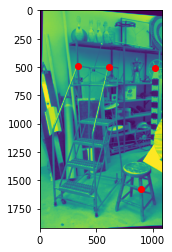

In [ ]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

#### test the same for custom depth map

In [ ]:
from src.dmcpworkflow.capture_depth import generate_depth_map
import pyrender
pmesh = pyrender.Mesh.from_points(mesh.points, mesh["colors"])
tup = generate_depth_map(pmesh,cam,znear=10,zfar=1000000000)

[[      0.41      -0.29       0.86  -16253.81]
 [     -0.11       0.92       0.37   -2188.84]
 [     -0.91      -0.25       0.34   -5136.69]]
[[      0.41       0.29      -0.86]
 [     -0.11      -0.92      -0.37]
 [     -0.91       0.25      -0.34]]
[[ -16253.81]
 [  -2188.84]
 [  -5136.69]]


[[   1733.68       0.00     819.72]
 [      0.00    1733.68     957.55]
 [      0.00       0.00       1.00]]


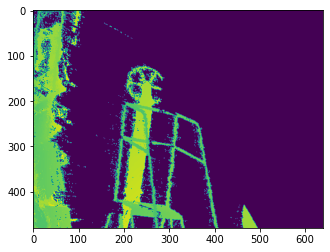

In [ ]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [60]:
from src.dmcpworkflow.annotate_points import annotate
mpl.use("QT5Agg")
_cps = annotate(im[:,:,0],_dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(_cps)

[[   1018.69     510.43     252.28     164.86]
 [    684.36     502.53     321.25     231.24]
 [    613.28     489.37     361.76     251.06]
 [    365.82     984.29     222.98     445.88]]


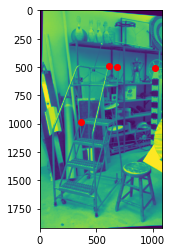

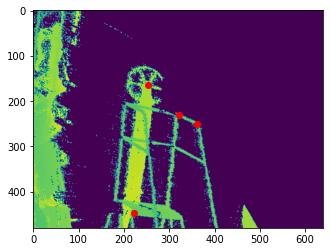

In [61]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(_cps[:,0],_cps[:,1],c="r")

plt.figure()
plt.imshow(_dm,origin="upper")
plt.scatter(_cps[:,2],_cps[:,3],c="r")

plt.show()

In [62]:
_world_pts = dm_to_world(_dm, _dmK, _dmP,_cps[:,2:])
_world_pts

array([[   1118.69,   -2587.90,    9975.31],
       [   -593.34,   -1989.36,    7590.87],
       [   -846.09,   -1853.72,    6875.80],
       [  -2001.88,     126.58,    7665.66]], dtype=float32)

In [63]:
cps_mesh = pv.PolyData(_world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [64]:
_A = dmcp(_dmK, P_im, _cps[:,:2],_world_pts)
print(f"A\n{_A}")

estimated pose
[[      1.00       0.01       0.01     -47.16]
 [     -0.01       1.00       0.00     -31.04]
 [     -0.01      -0.00       1.00      26.41]]
scale factor 0.9999999973202751
0.9999999924249008
A
[[      0.67       0.66      -0.34    -248.53]
 [      0.29       0.19       0.94     108.26]
 [      0.68      -0.73      -0.06      19.72]
 [      0.00       0.00       0.00       1.00]]


In [65]:
_P_trans = P_im @ la.inv(_A)

print("pose (mm)")
_pos_est = la.null_space(_P_trans) / la.null_space(_P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

_pos_est = _pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
_pos_est 

pose (mm)


array([    -47.16,     -31.04,      26.41])

In [66]:
sv_est = pv.Sphere(center=_pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()